In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

import numpy as np
from itertools import chain, combinations, combinations_with_replacement
from scipy.special import erfc
import pickle as pk
from time import time

# utility functions
def save_pk(data, file):
    with open(file, 'wb') as f:
        pk.dump(data, f)


In [5]:
def generate_vectors(vector_set, n):
    # get all possible combinations of the basis vectors
    vectors = list(chain.from_iterable(combinations_with_replacement(vector_set, i) for i in range(1, n+1)))
    # add the combinations together
    vectors = [np.sum(np.concatenate(x, axis=-1), axis=-1) for x in vectors]
    # remove the zero vectors
    vectors = np.array([x for x in vectors if not np.sum(x == 0., axis=-1) == 3])
    # remove the copies
    return np.unique(vectors, axis=0)

def compute_volume(v1, v2, v3):
    cross = np.cross(v2, v3, axisa=0, axisb=0)
    box = np.sum(v1 * cross)
    return np.abs(np.squeeze(box))

def vector_sub(v1, v2):
    return np.expand_dims(v1, axis=2) - np.expand_dims(v2, axis=1)

def vector_add(v1, v2):
    return np.expand_dims(v1, axis=2) + np.expand_dims(v2, axis=1)

def compute_distances(v1, v2):
    inter_vector = vector_sub(v1, v2)
    return np.sqrt(np.sum(inter_vector**2, axis=-1))

def inner(v1, v2):
    return np.sum(v1 * v2, axis=-1)

In [ ]:
#https://unlcms.unl.edu/cas/physics/tsymbal/teaching/SSP-927/Section%2001_Crystal%20Structure.pdf

basis_cell = np.array([[-0.5, 0.5, 0.5],
                       [0.5, -0.5, 0.5],
                       [0.5, 0.5, -0.5]])
inv_cell_basis = np.linalg.inv(basis_cell)

cv1, cv2, cv3 = np.split(basis_cell, 3, axis=1)
print('primitive vectors: ', '\n', cv1, '\n', cv2, '\n', cv3)
volume = compute_volume(cv1, cv2, cv3)
print('volume', volume)
vector_set = [cv1, -cv1, cv2, -cv2, cv3, -cv3]

rv1 = 2 * np.pi * np.cross(cv2, cv3, axisa=0, axisb=0) / volume
rv2 = 2 * np.pi * np.cross(cv3, cv1, axisa=0, axisb=0) / volume
rv3 = 2 * np.pi * np.cross(cv1, cv2, axisa=0, axisb=0) / volume

print('recipricol vectors: ', '\n', rv1, '\n', rv2, '\n', rv3)
vector_set_recip = [x.transpose() for x in (rv1, -rv1, rv2, -rv2, rv3, -rv3)]

n_walkers = 50
n_el = 4

walkers = np.random.uniform(0, 1., (n_walkers, n_el, 3))
talkers = walkers.dot(inv_cell_basis)
talkers = np.fmod(talkers, 1.)
talkers = np.where(talkers < 0, talkers + 1., talkers)
walkers = talkers.dot(basis_cell)

In [34]:
# show the direct sum converges 

def direct_sum(walkers, n):
    lattice_vectors = generate_vectors(vector_set, n)
    
    e_e_vectors = vector_sub(walkers, walkers)
    e_e_distances = compute_distances(walkers, walkers)
    e_e_Rs0 = np.tril(1. / e_e_distances, k=-1)

    # compute the Rs > 0 term
    ex_walkers = vector_add(walkers, lattice_vectors[None, ...])
    tmp = walkers[..., None, None, :] - ex_walkers[:, None, ...]
    ex_distances = np.sqrt(np.sum(tmp**2, axis=-1))
    e_e_Rs1 = np.sum(1. / ex_distances, axis=-1)
    
    return np.mean(np.sum(e_e_Rs0 + e_e_Rs1, axis=(-1,-2)))

ns = range(2, 15)
es = []
for n in ns:
    t0 = time()
    e = direct_sum(walkers, n)
    es.append(e)
    t1 = time()
    print(n, t1 - t0)

print(ns, es)


<ipython-input-34-8d67fd83f81e>:8: RuntimeWarning: divide by zero encountered in true_divide
  e_e_Rs0 = np.tril(1. / e_e_distances, k=-1)


2 0.0040013790130615234
3 0.006569623947143555
4 0.00957798957824707
5 0.020964384078979492
6 0.03403830528259277
7 0.045539140701293945
8 0.06703042984008789
9 0.13408327102661133
10 0.16695904731750488
11 0.25141239166259766
12 0.3769364356994629
13 0.5225837230682373
14 0.7186505794525146
range(2, 15) [347.17265386125706, 681.7049754477708, 1126.7503640328869, 1683.1373604711362, 2350.820207752624, 3129.7742303479, 4020.007685676138, 5021.52028845834, 6134.311803739637, 7358.382369430283, 8693.732006056689, 10140.360726047546, 11698.268540994022]


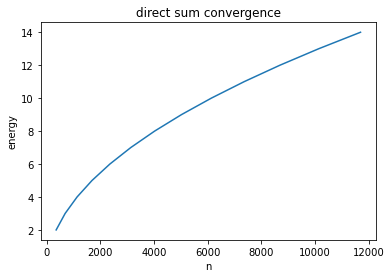

In [35]:
fig, ax = plt.subplots()
ax.plot(np.array(es), np.array(ns))
ax.set_xlabel('n')
ax.set_ylabel('energy')
ax.set_title('direct sum convergence')
plt.show()

primitive vectors:  
 [[-0.5]
 [ 0.5]
 [ 0.5]] 
 [[ 0.5]
 [-0.5]
 [ 0.5]] 
 [[ 0.5]
 [ 0.5]
 [-0.5]]
volume 0.5
recipricol vectors:  
 [[0.         6.28318531 6.28318531]] 
 [[6.28318531 0.         6.28318531]] 
 [[6.28318531 6.28318531 0.        ]]


In [22]:
def compute_potential(walkers, kappa, n, test=False):
    lattice_vectors = generate_vectors(vector_set, n)
    r_vectors = generate_vectors(vector_set_recip, n)

    # compute the Rs0 term
    e_e_vectors = vector_sub(walkers, walkers)
    e_e_distances = compute_distances(walkers, walkers)
    e_e_Rs0 = np.tril(erfc(kappa * e_e_distances) / e_e_distances, k=-1)  # is half the value

    # compute the Rs > 0 term
    ex_walkers = vector_add(walkers, lattice_vectors[None, ...])
    tmp = walkers[..., None, None, :] - ex_walkers[:, None, ...]
    ex_distances = np.sqrt(np.sum(tmp**2, axis=-1))
    e_e_Rs1 = np.sum(erfc(kappa * ex_distances) / ex_distances, axis=-1)

    # compute the constant factor
    self_interation = np.diag(np.array([2 * kappa / np.sqrt(np.pi)]).repeat(walkers.shape[1], axis=0))[None, ...]
    constant = np.pi / (kappa**2 * volume)

    # compute the reciprocal term reuse the ee vectors
    exp = np.exp(1j * e_e_vectors @ np.transpose(r_vectors))
    r_inner = inner(r_vectors, r_vectors) 
    r_factor = (4 * np.pi / volume) * (np.exp(- r_inner / (4 * kappa**2)) / r_inner)[None, None, None, ...] * exp
    r_term = np.real(np.sum(r_factor, axis=-1)) - self_interation #- constant
    
    average_potential = np.sum(e_e_Rs0 + 0.5 * e_e_Rs1 + 0.5 * r_term, axis=(-1,-2)) 
    
    if test:
        print(lattice_vectors.shape, r_vectors.shape)
        print(e_e_Rs0.shape, e_e_Rs1.shape, r_term.shape)
        
    return np.mean(np.sum(e_e_Rs0, axis=(-1,-2))), np.mean(0.5 * np.sum(e_e_Rs1, axis=(-1,-2))), \
np.mean(0.5 * np.sum(r_term, axis=(-1,-2))), np.mean(average_potential)

# unit test
compute_potential(walkers, 1., 5, test=True)

(230, 3) (230, 3)
(50, 4, 4) (50, 4, 4) (50, 4, 4)


<ipython-input-22-e93176bb94c3>:8: RuntimeWarning: divide by zero encountered in true_divide
  e_e_Rs0 = np.tril(erfc(kappa * e_e_distances) / e_e_distances, k=-1)  # is half the value


(7.753352972350491, 37.157789832463344, -2.256758313032318, 42.654384491781514)

<ipython-input-22-e93176bb94c3>:8: RuntimeWarning: divide by zero encountered in true_divide
  e_e_Rs0 = np.tril(erfc(kappa * e_e_distances) / e_e_distances, k=-1)  # is half the value


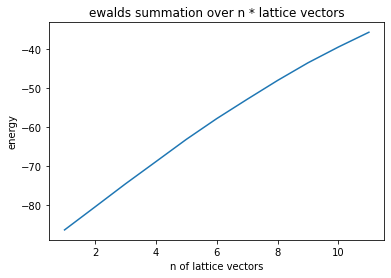

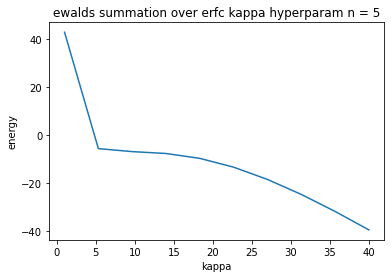

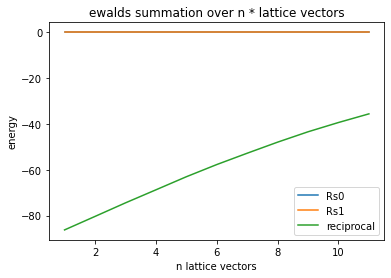

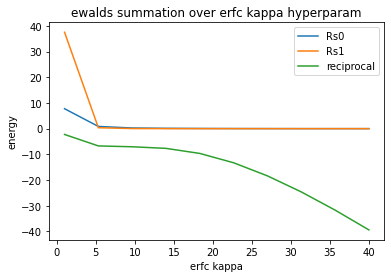

In [23]:
# plot kappa vs potential 
# plot potential vs n
# for the real and reciprocal lattice

ns = range(1, 12)
n_results = []
for n in ns:
    e_e_Rs0, e_e_Rs1, r_term, mean = compute_potential(walkers, 40., n)
    n_results.append([40., n, e_e_Rs0, e_e_Rs1, r_term, mean])
n_results = np.array(n_results)
save_pk(np.array(n_results), 'n_results.pk')

kappas = np.linspace(1., 40., 10)

k_results = []
for k in kappas:
    e_e_Rs0, e_e_Rs1, r_term, mean = compute_potential(walkers, k, 10)
    k_results.append([k, 10, e_e_Rs0, e_e_Rs1, r_term, mean]) 
k_results = np.array(k_results)
save_pk(np.array(k_results), 'k_results.pk')

fig, ax = plt.subplots()
ax.plot(n_results[:, 1], n_results[:, -1])
ax.set_xlabel('n of lattice vectors')
ax.set_ylabel('energy')
ax.set_title('ewalds summation over n * lattice vectors')
plt.show()

fig, ax = plt.subplots()
ax.plot(k_results[:, 0], k_results[:, -1])
ax.set_xlabel('kappa')
ax.set_ylabel('energy')
ax.set_title('ewalds summation over erfc kappa hyperparam n = 5')
plt.show()

fig, ax = plt.subplots()
for i, l in enumerate(['Rs0', 'Rs1', 'reciprocal']):
    ax.plot(n_results[:, 1], n_results[:, i+2], label=l)
    ax.set_xlabel('n lattice vectors')
    ax.set_ylabel('energy')
    ax.set_title('ewalds summation over n * lattice vectors')
ax.legend()
plt.show()

fig, ax = plt.subplots()
for i, l in enumerate(['Rs0', 'Rs1', 'reciprocal']):
    ax.plot(k_results[:, 0], k_results[:, i+2], label=l)
    ax.set_xlabel('erfc kappa')
    ax.set_ylabel('energy')
    ax.set_title('ewalds summation over erfc kappa hyperparam')
ax.legend()
plt.show()


In [12]:
ns = range(4, 10)
kappas = np.linspace(5, 100, 10)

nk_results = []
for n in ns:
    k_results = []
    for k in kappas:
        e_e_Rs0, e_e_Rs1, r_term, mean = compute_potential(k, n)
        results = [n, k, e_e_Rs0, e_e_Rs1, r_term, mean]
        k_results.append(results) 
        print(results)
        
    nk_results.append(k_results)
    
nk_results = np.array(nk_results)
print(nk_results.shape)


<ipython-input-8-3b1efe9832f0>:9: RuntimeWarning: divide by zero encountered in true_divide
  e_e_Rs0 = np.sum(np.tril(erfc(kappa * e_e_distances) / e_e_distances, k=-1), axis=(-1, -2))  # is half the value


[4, 5.0, 1.188045650582493, 0.4229917152158101, 2.5364533201756445, 4.147490685973947]
[4, 15.555555555555555, 0.1374517537927766, 0.0026348736118508693, 17.0296587622941, 17.16974538969873]
[4, 26.11111111111111, 0.01806438913986462, 5.554077045059591e-06, 20.255809129637804, 20.273879072854715]
[4, 36.666666666666664, 0.0015815550827741472, 8.848691714725486e-10, 21.30744991027958, 21.30903146624722]
[4, 47.22222222222222, 8.291062019431887e-05, 8.93643467056293e-15, 21.763739793461323, 21.763822704081527]
[4, 57.77777777777778, 2.351566805586939e-06, 5.5572304354765825e-21, 22.00002468704962, 22.000027038616427]
[4, 68.33333333333333, 3.486143522722193e-08, 2.0971090507426915e-28, 22.13751175626708, 22.137511791128514]
[4, 78.88888888888889, 2.675186303173745e-10, 4.760728366936674e-37, 22.22434567643717, 22.224345676704687]
[4, 89.44444444444444, 1.0576899201346406e-12, 6.465362933510837e-47, 22.282615006234405, 22.282615006235464]
[4, 100.0, 2.14777477826494e-15, 5.232843196704809

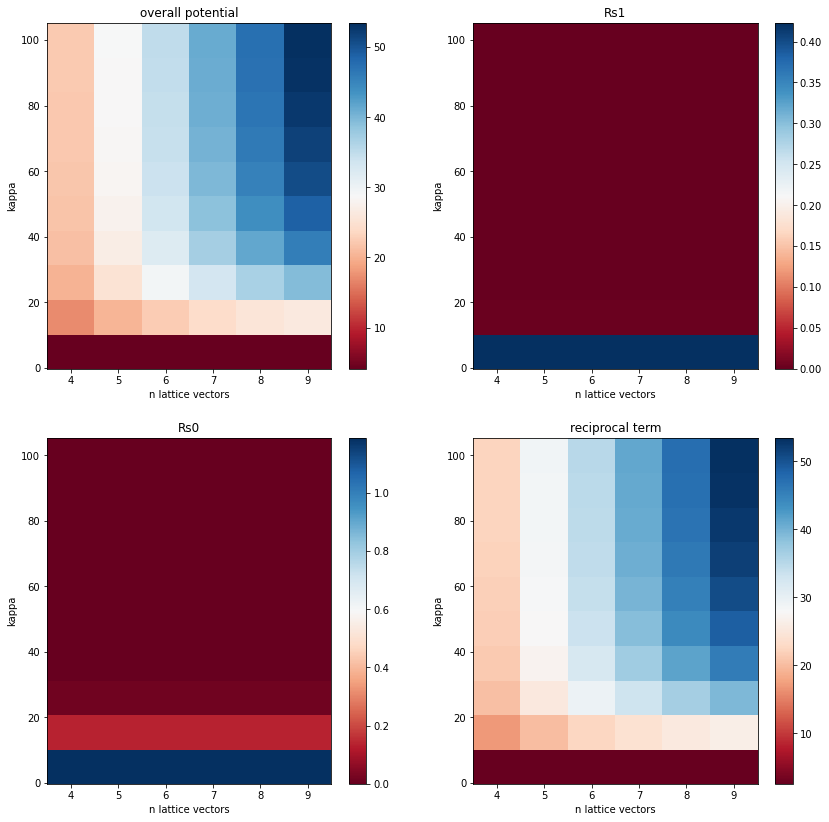

In [13]:


fig, axs = plt.subplots(2, 2, figsize=(14,14))
X, Y, Z = nk_results[:,:,0], nk_results[:,:,1], nk_results[:,:,-1]
p = axs[0,0].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
axs[0,0].set_title('overall potential')
axs[0,0].set_xlabel('n lattice vectors')
axs[0,0].set_ylabel('kappa')
cb = fig.colorbar(p, ax=axs[0,0])
# plt.show()

# fig, ax = plt.subplots()
X, Y, Z = nk_results[:,:,0], nk_results[:,:,1], nk_results[:,:,-4]
p = axs[1,0].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
axs[1,0].set_title('Rs0')
axs[1,0].set_xlabel('n lattice vectors')
axs[1,0].set_ylabel('kappa')
cb = fig.colorbar(p, ax=axs[1,0])
# plt.show()

# fig, ax = plt.subplots()
X, Y, Z = nk_results[:,:,0], nk_results[:,:,1], nk_results[:,:,-3]
p = axs[0,1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
axs[0,1].set_title('Rs1')
axs[0,1].set_xlabel('n lattice vectors')
axs[0,1].set_ylabel('kappa')
cb = fig.colorbar(p, ax=axs[0,1])
# plt.show()

# fig, ax = plt.subplots()
X, Y, Z = nk_results[:,:,0], nk_results[:,:,1], nk_results[:,:,-2]
p = axs[1,1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
axs[1,1].set_title('reciprocal term')
axs[1,1].set_xlabel('n lattice vectors')
axs[1,1].set_ylabel('kappa')
cb = fig.colorbar(p, ax=axs[1,1])
plt.show()

Text(0.5, 1.0, 'erfc function / distance')

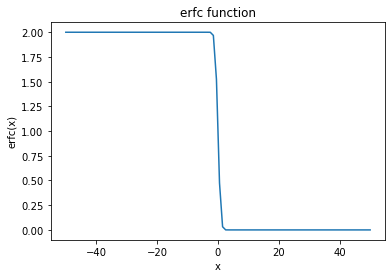

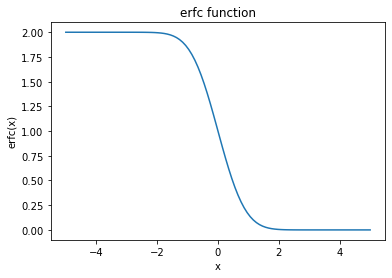

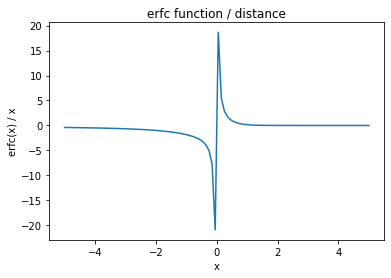

In [11]:
# ex_walkers = vector_add(walkers, lattice_vectors[None, ...]).reshape(n_walkers, -1, 3)
#     ex_distances = compute_distances(walkers, ex_walkers)
#     e_e_Rs1 = 0.5 * np.sum(erfc(kappa * ex_distances) / ex_distances, axis=(-1, -2))
#     print(e_e_Rs1.shape)
    
fig, ax = plt.subplots()
x = np.linspace(-50, 50, 100)
ax.plot(x, erfc(x))
ax.set_xlabel('x')
ax.set_ylabel('erfc(x)')
ax.set_title('erfc function')

fig, ax = plt.subplots()
x = np.linspace(-5, 5, 100)
ax.plot(x, erfc(x))
ax.set_xlabel('x')
ax.set_ylabel('erfc(x)')
ax.set_title('erfc function')

fig, ax = plt.subplots()
x = np.linspace(-5, 5, 100)
ax.plot(x, erfc(x) / x)
ax.set_xlabel('x')
ax.set_ylabel('erfc(x) / x')
ax.set_title('erfc function / distance')

230 230
5 39.265187920699006 230
376 376
6 39.76399598928982 376
574 574
7 39.93234408447498 574
832 832
8 39.98397341629998 832
1158 1158
9 39.99841563429688 1158
1560 1560
10 40.001935997098734 1560
2046 2046
11 40.0026951531989 2046
2624 2624
12 40.00284069575018 2624
3302 3302
13 40.002864875904365 3302
4088 4088
14 40.00286837782569 4088


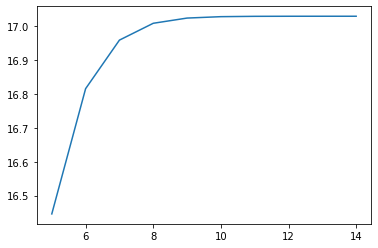

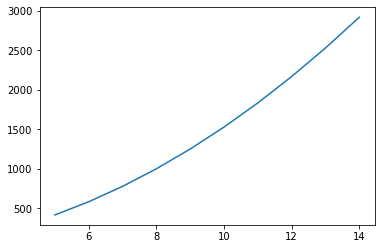

In [12]:
kappa = 1.
sums = []
for n in range(5, 15):
    lattice_vectors = generate_vectors(vector_set, n)
    n_l = len(lattice_vectors)
    lattice_vectors = np.unique(lattice_vectors, axis=0)
    print(n_l, len(lattice_vectors))
    ex_walkers = vector_add(walkers, lattice_vectors[None, ...])
    ex_walkers = np.reshape(ex_walkers, (n_walkers, -1, 3))
    ex_distances = compute_distances(walkers, ex_walkers)
    e_e_Rs1 = 0.5 * np.sum(erfc(kappa * ex_distances) / ex_distances, axis=(-1, -2))
    print(n, np.mean(e_e_Rs1), len(lattice_vectors))
    ex_distances = np.reshape(ex_distances, (n_walkers, n_el, n_el, len(lattice_vectors)))
#     fig, ax = plt.subplots()
    x = np.sort(1. / np.mean(ex_distances, axis=(0, 1, 2)))[::-1]
#     ax.plot(range(len(lattice_vectors)), x, label='rs')
#     ax.plot(range(len(lattice_vectors)), erfc(1./x), label='erfc')
#     ax.plot(range(len(lattice_vectors)), x * erfc(1./x), label='erfc')
    

#     ax.set_xlabel('convergence of 1/r')
#     ax.set_ylabel('1/r')
#     ax.set_title('r')
    
    sums.append([n, np.mean(np.sum(erfc(kappa * ex_distances), axis=(-1, -2))), np.mean(np.sum(1. / ex_distances, axis=(-1,-2)))])

sums = np.array(sums)

fig, ax = plt.subplots()
ax.plot(sums[:,0], sums[:,1], label='erfc')

fig, ax = plt.subplots()
ax.plot(sums[:,0], sums[:,2], label='1/x')

    # print(np.mean(ex_distances, axis=(0, 1, 2)))

In [13]:
a = np.array([[1, 0, 0], [1, 0, 0], [1.5, 0.5, 0.], [1.5, 0.5, 0.1], [2, 3, 4]])
np.unique(a, axis=0)


array([[1. , 0. , 0. ],
       [1.5, 0.5, 0. ],
       [1.5, 0.5, 0.1],
       [2. , 3. , 4. ]])